# MORDM

Many Objectives Decision Making

MORDM has four main steps:

(i) problem formulation based on a systems analytical problem definition framework

(ii) searching for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms

(iii) generating an ensemble of scenarios to explore the effects of uncertainties

(iv) using scenario discovery to detect the vulnerabilities of candidate solutions and improving thecandidate solutions

In [1]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    perform_experiments,
    Samplers,
    Scenario,
    ScalarOutcome
)
import numpy as np
import pandas as pd
import copy
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time, min_over, guaranteed95_over, guaranteed98_over

from ema_workbench.em_framework.optimization import EpsilonProgress

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Select problem formulation 3 - Water Levels
ema_logging.log_to_stderr(ema_logging.INFO)
dike_model, planning_steps = get_model_for_problem_formulation(3)

## Problem Formulation


The room for the river model has 6 outcome indicators. The first four indicators are specific to each dike and the last two concern the model as a whole:
- Expected Annual Damage
- Expected Number of Deaths
- Dike Investment Costs
- Water Level
- RfR Total Costs
- Expected Evacuation Costs

As analysts for the transport company, the capacity to transport goods in the river is heavily dependent on the water level staying above a threshold. Therefore, it is crucial for the problem owner to focus on the policies where this target is met. Nonetheless, based on the insights provided by the different stakeholders during the debate, it becomes imperative to explore options that have the desired water level with the least amount of casualties and costs.

In [3]:
# Model Uncertainties
for uncertainty in dike_model.uncertainties:
    print(repr(uncertainty))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [4]:
# Policy Levers
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [5]:
# Model Outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x0000028B4E5E59E0>)
ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x0000028B4E5E59E0>)
ScalarOutcome('A.1_Minimum Water Level', variable_name=('A.1_Water Level',), function=<function min_over at 0x0000028B00B07EC0>)
ScalarOutcome('A.1_95% Guaranteed Water Level', variable_name=('A.1_Water Level',), function=<function guaranteed95_over at 0x0000028B0103ED40>)
ScalarOutcome('A.1_98% Guaranteed Water Level', variable_name=('A.1_Water Level',), function=<function guaranteed98_over at 0x0000028B0103EDE0>)
ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x0000028B4E5E59E0>)
ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<funct

## Candidate Strategies

### Option 1: MORDM
Direct search is used to go through the decision levers to find good candidate strategies that meet the desired outcomes of the problem owner. This method is based on a reference scenario.

In [6]:
# Define a reference scenario. JUST AN EXAMPLE

reference_scenario = Scenario('reference', **{'discount rate 0': 2.5,
                                              'discount rate 1': 2.5,
                                              'discount rate 2': 2.5,
                                              'A.0_ID flood wave shape': 75,
                                              'A.1_Bmax': 190, 'A.1_pfail': (0.2 - 0.0005)/2, 'A.1_Brate': 1.5,
                                              'A.2_Bmax': 190, 'A.2_pfail': 0.5, 'A.2_Brate': 1.5,
                                              'A.3_Bmax': 190, 'A.3_pfail': 0.5, 'A.3_Brate': 1.5,
                                              'A.4_Bmax': 190, 'A.4_pfail': 0.5, 'A.4_Brate': 1.5,
                                              'A.5_Bmax': 190, 'A.5_pfail': 0.5, 'A.5_Brate': 1.5})

In [7]:
# Define metrics for the optimization
convergence_metrics = [EpsilonProgress()]
epsilon = [0.1,] * len(dike_model.outcomes)
nfe = 50000  # proof of principle only, way to low for actual use

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(
        nfe=nfe,
        searchover="levers",
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario,
        )

[MainProcess/INFO] pool started with 12 workers
54965it [2:01:16,  7.55it/s]                                                   
[MainProcess/INFO] optimization completed, found 8358 solutions
[MainProcess/INFO] terminating pool


In [2]:
results
results.to_excel('MORDM.xlsx')
convergence.to_excel('Convergence.xlsx')

#Build the list of column names dynamically
water_level_columns = [
    'A.1_Minimum Water Level',
    'A.2_Minimum Water Level',
    'A.3_Minimum Water Level',
    'A.4_Minimum Water Level',
    'A.5_Minimum Water Level'
]
# Pareto policies that fulfill defined criteria- Water level above 4
policies = results[(results[water_level_columns] > 4).all(axis=1)]

policies.to_excel('Policies.xlsx')


NameError: name 'results' is not defined

In [23]:
len(policies)

8358

In [24]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_Minimum Water Level,A.4_95% Guaranteed Water Level,A.4_98% Guaranteed Water Level,A.5 Total Costs,A.5_Expected Number of Deaths,A.5_Minimum Water Level,A.5_95% Guaranteed Water Level,A.5_98% Guaranteed Water Level,RfR Total Costs,Expected Evacuation Costs
0,1,0,1,1,1,1,1,1,1,0,...,5.0828,5.0828,5.0828,1.787302e+08,0.000000,4.2987,4.2987,4.2987,1.413200e+09,0.000000
1,1,1,1,0,0,0,1,0,1,1,...,5.1328,5.1328,5.1328,1.463574e+08,0.000000,4.2987,4.2987,4.2987,5.576000e+08,0.000000
2,1,1,1,1,0,1,1,0,1,1,...,5.1328,5.1328,5.1328,1.472613e+08,0.000000,4.2987,4.2987,4.2987,9.932000e+08,555.891946
3,1,0,0,1,1,1,1,1,1,0,...,5.1528,5.1528,5.1528,1.472613e+08,0.000000,4.5387,4.5387,4.5387,1.342300e+09,0.000000
4,1,0,0,1,1,0,1,1,0,1,...,4.9828,4.9828,4.9828,1.766103e+08,0.000000,4.2987,4.2987,4.2987,1.592300e+09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,0,0,1,0,0,1,1,0,0,0,...,5.1328,5.1328,5.1328,3.667668e+07,0.000000,4.2987,4.2987,4.2987,5.755000e+08,537.387137
8354,1,1,1,0,0,1,0,1,0,1,...,5.1328,5.1328,5.1328,7.923200e+07,0.000000,4.2987,4.2987,4.2987,7.447000e+08,749.071501
8355,1,1,0,0,0,0,0,0,0,1,...,5.0228,5.0228,5.0228,7.258061e+07,0.000000,4.1787,4.1787,4.1787,7.889000e+08,1928.958094
8356,1,0,1,0,0,1,1,1,1,0,...,5.2028,5.2028,5.2028,1.113090e+08,0.003822,4.5387,4.5387,4.5387,7.352000e+08,2648.552169


<>:13: SyntaxWarning: invalid escape sequence '\e'
<>:13: SyntaxWarning: invalid escape sequence '\e'
C:\Users\lilac\AppData\Local\Temp\ipykernel_1108\888765605.py:13: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel('$\epsilon$-progress')


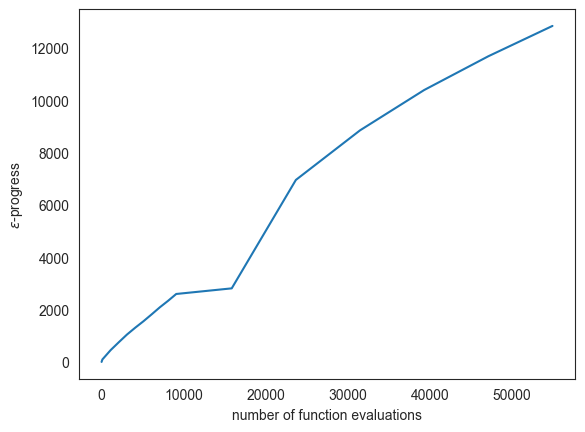

In [25]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
#fig, ax1 = plt.subplots(ncols=1)
#ax1.plot(convergence.epsilon_progress)
#ax1.set_xlabel("nr. of generations")
#ax1.set_ylabel(r"$\epsilon$ progress")
#sns.despine()

import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

In [26]:
# Create a list with a format EMA workbench can use
from ema_workbench import Policy

policies.index = [i for i in range(len(policies.index))]

# Drop the outcome columns from the policies DataFrame, keeping only the decision variables
policies_pareto = policies.drop([o.name for o in dike_model.outcomes], axis=1)

policies_to_analyze = []

# Create policy objects
for i, policy in policies.iterrows():
    policies_to_analyze.append(Policy(str(i), **policy.to_dict()))


C:\Users\lilac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


<Figure size 3000x500 with 0 Axes>

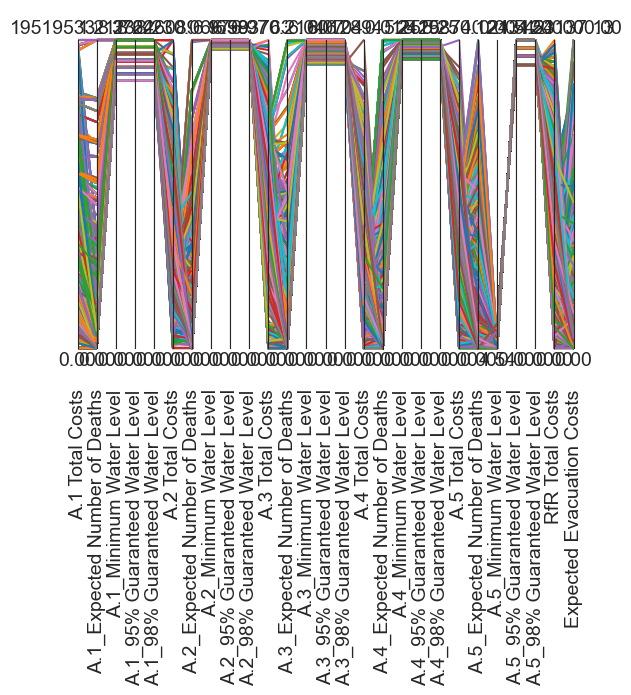

In [34]:
from ema_workbench.analysis import parcoords


data = results.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

plt.figure(figsize=(30, 5))
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
#paraxes.invert_axis('A.5_Minimum Water Level')
plt.show()

## Candidate Strategies
Re evaluate candidate solutions to assess their robustness. Run EMA workbench again. Reduce the size of the list of the robust policies by adding extra constaints (Insights on the debate)


In [1]:
# Filter results based on the total costs being below a threshold. TBC with debate insights

results_filter = results[results['RfR Total Costs']< 1000000000]
results_filter.to_excel('Results Filter.xlsx')
len(results_filter)

NameError: name 'results' is not defined

In [ ]:
data = results_filter.loc[:, [o.name for o in dike_model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in dike_model.outcomes]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [ ]:
# Run experiments again only on selected robust policies
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_analyze)

experiments, outcomes = results

# Plot outcomes
sns.pairplot(pd.DataFrame(outcomes))

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 1000 scenarios * 8358 policies * 1 model(s) = 8358000 experiments
  0%|                               | 1300/8358000 [02:51<214:39:09, 10.81it/s]

In [ ]:
# Outcomes distribution
sns.boxplot(pd.DataFrame(outcomes))

In [ ]:
# Calculate values below the 10th percentile. (Lowest RfR Costs)
#y= outcomes['RfR Total Costs']>np.percentile(outcomes['RfR Total Costs'],10)

**Robustness metric:** Maximum Regret, defined for each policy under each scenario, as the difference between the performance of the policy in a specific scenario and the performance of a no-regret (i.e. best possible result in that scenario) policy. The maximum regret is then the maximum of such regret values across all scenarios. We of course favor policy options with low maximum regret values.

In [ ]:
overall_regret = {}
max_regret = {}

for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting.
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across
    # the row and the actual values in the row
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()


### Option 2: Multi Scenario MORDM - Search over decision levers given a set of scenarios
Search over the levers for solutions that have robust performance over a set of scenarios

In [56]:
import functools

# Robustness functions
percentile10 = functools.partial(np.percentile, q=10)
percentile90 = functools.partial(np.percentile, q=90)



# Definition of kinds - To ask oscar
MINIMIZE = ScalarOutcome.MINIMIZE



In [ ]:
#A robustness metric takes as input the performance of a candidate policy over a set of scenarios and returns a single robustness score.
# THIS IS A TEST
robustness_functions = [
    ScalarOutcome(
        "90th percentile RFR Total Costs", kind=MINIMIZE, variable_name= "RfR Total Costs", function=percentile10
    )
]

With the robustness metrics specified, and the scenarios, sampled, we can now perform robust many-objective optimization. This is computationally very expensive since each candidate solution is going to be run for ten scenarios before we can calculate the robustness for each outcome of interest.

In [57]:
from ema_workbench.em_framework import sample_uncertainties

n_scenarios = 10
scenarios = sample_uncertainties(dike_model, n_scenarios)

In [58]:
from ema_workbench.em_framework import ArchiveLogger

nfe = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    robust_results = evaluator.robust_optimize(
        robustness_functions,
        scenarios,
        nfe=nfe,
        epsilons=[
            0.025,
        ]
        * len(robustness_functions),
    )

[MainProcess/INFO] pool started with 12 workers
100%|████████████████████████████████████████| 200/200 [03:41<00:00,  1.11s/it]
[MainProcess/INFO] optimization completed, found 1 solutions
[MainProcess/INFO] terminating pool


In [55]:
robust_results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,90th percentile RFR Total Costs
0,0,0,0,0,0,0,0,0,0,0,...,2,4,7,9,0,7,9,6,9,0.0


In [54]:
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt

# Prepare data
data = robust_results.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, [o.name for o in robustness_functions]] = 0

# Create plot
paraxes = parcoords.ParallelAxes(limits) # Pass the axis explicitly
paraxes.plot(data)
paraxes.invert_axis("90th percentile RFR Total Costs")
plt.show()


UnboundLocalError: cannot access local variable 'ax' where it is not associated with a value

<Figure size 640x480 with 0 Axes>